In [19]:
import json
import requests

import torch
import torch.nn as nn
import torch.optim
from torch.autograd import Variable

import re
import jieba
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import os
os.chdir('/Users/dengyi/Desktop/program_instances/pytorch_practice')

In [20]:
def get_comments(url):
    comments = []
    resp = requests.get(url)
    resp.encoding = 'gbk'

    if resp.status_code != 200:
        return []

    content = resp.text
    if content:
        ind = content.find('(')
        s1 = content[ind+1:-2]
        try:
            js = json.loads(s1)
            comment_infos = js['comments']
        except:
            print('error')
            return []
        
        for comment_info in comment_infos:
            comment_content = comment_info['content']
            str1 = comment_content + '\n'
            comments.append(str1)
    
    return comments

In [21]:
# score 设为 3，表示好评
good_comment_url_templates = [
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv8914&productId=10359162198&score=3&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv73&productId=10968941641&score=3&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv4653&productId=10335204102&score=3&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv1&productId=1269194114&score=3&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv2777&productId=1409704820&score=3&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv174&productId=10103790891&score=3&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv9447&productId=1708318938&score=3&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv111&productId=10849803616&score=3&sortType=5&page={}&pageSize=10&isShadowSku=0'
]

In [22]:
# good_comments = []

# for good_comment_url_template in good_comment_url_templates:
#     for i in range(100):
#         url = good_comment_url_template.format(i)
#         good_comments += get_comments(url)
#         print('第{}条记录，总文本长度{}'.format(i, len(good_comments)))

# fw = open('comment_data/good.txt', 'w')
# fw.writelines(good_comments)
# fw.close()
# print('Finished')

In [23]:
# score 设为 1，表示差评
bad_comment_url_templates = [
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv8914&productId=10359162198&score=1&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv73&productId=10968941641&score=1&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'http://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv4653&productId=10335204102&score=1&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv1&productId=1269194114&score=1&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv2777&productId=1409704820&score=1&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv174&productId=10103790891&score=1&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv9447&productId=1708318938&score=1&sortType=5&page={}&pageSize=10&isShadowSku=0',
    'https://club.jd.com/comment/productPageComments.action?callback=fetchJSON_comment98vv111&productId=10849803616&score=1&sortType=5&page={}&pageSize=10&isShadowSku=0'
]

In [24]:
# bad_comments = []

# for bad_comment_url_template in bad_comment_url_templates:
#     for i in range(100):
#         url = bad_comment_url_template.format(i)
#         bad_comments += get_comments(url)
#         print('第{}条纪录，总文本长度{}'.format(i, len(bad_comments)))

# fw = open('comment_data/bad.txt', 'w')
# fw.writelines(bad_comments)
# fw.close()
# print('Finished')

In [25]:
# 过滤标点符号
def filter_punctuation(sentence):
    sentence = re.sub("[\s+\.\!\/_,$%^*(+\"\'“”《》?“]+|[+——！，。？、~@#￥%……&*（）：]+", "", sentence)
    return sentence

# 分词、建立字典
# 字典项：{word: [id, count]}
def prepare_data(good_file, bad_file, is_filter=True):
    all_words = []
    pos_sentences = []
    neg_sentences = []
    with open(good_file, 'r') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                line = filter_punctuation(line)
            words = jieba.lcut(line)
            if len(words) > 0:
                all_words += words
                pos_sentences.append(words)
    count = len(all_words)
    print('{0} 包含 {1} 行，{2} 个词。'.format(good_file, idx+1, count))

    with open(bad_file, 'r') as fr:
        for idx, line in enumerate(fr):
            if is_filter:
                line = filter_punctuation(line)
            words = jieba.lcut(line)
            if len(words) > 0:
                all_words += words
                neg_sentences.append(words)
    print('{0} 包含 {1} 行，{2} 个词。'.format(bad_file, idx+1, len(all_words)-count))

    diction = {}
    cnt = Counter(all_words)
    for word, freq in cnt.items():
        diction[word] = [len(diction), freq]
    print('字典大小：{}'.format(len(diction)))

    return pos_sentences, neg_sentences, diction

In [26]:
# 根据 word 查 id
def word2index(word, diction):
    if word in diction:
        value = diction[word][0]
    else:
        value = -1
    return value

# 根据 id 查 word
def index2word(index, diction):
    for w, v in diction.items():
        if v[0] == index:
            return w
    return None

In [27]:
good_file = 'data/comment_data/good.txt'
bad_file = 'data/comment_data/bad.txt'

pos_sentences, neg_sentences, diction = prepare_data(good_file, bad_file, True)
st = sorted([(v[1], w) for w, v in diction.items()])
st

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/5b/sws7s1891bx1rlrkrscwxs_h0000gn/T/jieba.cache
Loading model cost 0.466 seconds.
Prefix dict has been built successfully.


data/comment_data/good.txt 包含 8089 行，100839 个词。
data/comment_data/bad.txt 包含 5076 行，56070 个词。
字典大小：7135


[(1, '---'),
 (1, '------'),
 (1, '000000000'),
 (1, '0000000000000000'),
 (1, '00000000000000000'),
 (1, '0000000000000000000000'),
 (1, '000000000000000000000000000'),
 (1, '00000000000000000000000000000000000000000000000'),
 (1, '1006'),
 (1, '111'),
 (1, '1111111'),
 (1, '11111111111'),
 (1, '11111111111111'),
 (1, '111111111111111111111111'),
 (1, '11111111111111111111111111111'),
 (1, '111111111111111111111111111111111'),
 (1, '1111111111111111111111111111111111111111111'),
 (1, '115'),
 (1, '122'),
 (1, '12315'),
 (1, '123456'),
 (1, '1255888'),
 (1, '128'),
 (1, '130'),
 (1, '136'),
 (1, '138'),
 (1, '15548'),
 (1, '158105'),
 (1, '160'),
 (1, '16067cm'),
 (1, '165140'),
 (1, '165cm'),
 (1, '166cm68kgxl'),
 (1, '16860'),
 (1, '170CM55'),
 (1, '170M'),
 (1, '170cm75kg'),
 (1, '171819202122'),
 (1, '172'),
 (1, '172153'),
 (1, '175cm'),
 (1, '1805'),
 (1, '180xxl'),
 (1, '183'),
 (1, '185'),
 (1, '1852XL'),
 (1, '185XXL'),
 (1, '185mm'),
 (1, '200000000'),
 (1, '20161218'),
 (1, 

In [28]:
def sentence2vec(sentence, diction):
    vector = np.zeros(len(diction))
    for l in sentence:
        vector[l] += l
    return (1.0 * vector / len(sentence))

In [29]:
dataset = []
labels = []
sentences = []

for sentence in pos_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            new_sentence.append(word2index(l, diction))
    dataset.append(sentence2vec(new_sentence, diction))
    labels.append(0)    # 好评为 0
    sentences.append(sentence)

for sentence in neg_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            new_sentence.append(word2index(l, diction))
    dataset.append(sentence2vec(new_sentence, diction))
    labels.append(1)    # 差评为 1
    sentences.append(sentence)

sentences

[['这', '应该', '是', '我', '在', '网上', '买', '裤子', '最', '喜欢', '的', '一条', '的', '太赞'],
 ['不错', '穿着', '舒服', '还', '不贵', '挺', '好'],
 ['穿着', '很', '舒服', '洗过', '也', '不缩水', '显', '瘦点', '赞'],
 ['今天',
  '的',
  '第一次',
  '穿刚',
  '坐下',
  '就',
  '发现',
  '裤边',
  '都',
  '开线',
  '了',
  '从',
  '没有',
  '买过',
  '这',
  '这么',
  '结实',
  '的',
  '衣服',
  '太',
  '耐穿',
  '了',
  '早上',
  '穿',
  '的',
  '到',
  '公司',
  '就要',
  '走光',
  '了',
  '这',
  '可是',
  '零下',
  '五度',
  '的',
  '天气',
  '啊',
  '我',
  '滴天'],
 ['老公', '很', '喜欢', '大小', '合适', '裤子', '不错'],
 ['经过',
  '我',
  '的',
  '亲身',
  '体验',
  '这家',
  '店',
  '信誉',
  '是',
  '相当',
  '地',
  '不错',
  '宝贝',
  '的',
  '质量',
  '更',
  '像',
  '钻石',
  '一般',
  '太',
  '感谢',
  '了'],
 ['掌柜的',
  '服务态度',
  '真',
  '好',
  '发货',
  '很快',
  '商品质量',
  '也',
  '相当',
  '不错',
  '太',
  '喜欢',
  '了',
  '谢谢'],
 ['掌柜的',
  '服务态度',
  '真',
  '好',
  '发货',
  '很快',
  '商品质量',
  '也',
  '相当',
  '不错',
  '太',
  '喜欢',
  '了',
  '谢谢'],
 ['掌柜的',
  '服务态度',
  '真',
  '好',
  '发货',
  '很快',
  '商品质量',
  '也',
  '相当',
  '不错',
  '太',
  

In [30]:
# indices 为所有数据下标的一个随机全排列
indices = np.random.permutation(len(dataset))

dataset = [dataset[i] for i in indices]
labels = [labels[i] for i in indices]
sentences = [sentences[i] for i in indices]

test_size = len(dataset) // 10

# 训练集
train_data = dataset[2*test_size : ]
train_label = labels[2*test_size : ]

# 验证集
valid_data = dataset[ : test_size]
valid_label = labels[ : test_size]

# 测试集
test_data = dataset[test_size : 2*test_size]
test_label = labels[test_size : 2*test_size]
# test_data

In [31]:
model = nn.Sequential(
    nn.Linear(len(diction), 10),
    nn.ReLU(),
    nn.Linear(10, 2),
    nn.LogSoftmax(dim=1)
)
cost = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [32]:
def rightness(predictions, labels):
    pred = torch.max(predictions.data, 1)[1]
    rights = pred.eq(labels.data.view_as(pred)).sum()
    return rights, len(labels)


In [33]:
records = []

losses = []

def train_model(data, label):
    x = Variable(torch.FloatTensor(data).view(1, -1))
    y = Variable(torch.LongTensor(np.array([label])))

    optimizer.zero_grad()
    predict = model(x)
    loss = cost(predict, y)
    losses.append(loss.data.numpy())
    loss.backward()
    optimizer.step()

In [34]:
def evaluate_model(data, label):
    x = Variable(torch.FloatTensor(data).view(1, -1))
    y = Variable(torch.LongTensor(np.array([label])))
    predict = model(x)
    right = rightness(predict, y)
    loss = cost(predict, y)

    return predict, right, loss

In [35]:
for epoch in range(100):
    for i, data in enumerate(zip(train_data, train_label)):
        x, y = data
        train_model(x, y)
    
        if i % 3000 == 0:
            val_losses = []
            rights = []
            for j, val in enumerate(zip(valid_data, valid_label)):
                x, y = val
                predict, right, loss = evaluate_model(x, y)
                rights.append(right)
                val_losses.append(loss.data.numpy())

            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}轮，训练损失：{:.2f}，校验损失：{:.2f}，校验准确率：{:.2f}'.format(epoch, np.mean(losses), 
                                                                                    np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])

第0轮，训练损失：0.91，校验损失：1.22，校验准确率：0.35
第0轮，训练损失：2.03，校验损失：4.01，校验准确率：0.83
第0轮，训练损失：2.09，校验损失：2.65，校验准确率：0.73
第0轮，训练损失：2.20，校验损失：2.93，校验准确率：0.86
第1轮，训练损失：2.23，校验损失：1.20，校验准确率：0.85
第1轮，训练损失：2.21，校验损失：1.96，校验准确率：0.84
第1轮，训练损失：2.15，校验损失：3.47，校验准确率：0.85
第1轮，训练损失：2.08，校验损失：4.18，校验准确率：0.83
第2轮，训练损失：2.11，校验损失：2.22，校验准确率：0.84
第2轮，训练损失：2.09，校验损失：3.14，校验准确率：0.86
第2轮，训练损失：2.09，校验损失：5.32，校验准确率：0.86
第2轮，训练损失：2.00，校验损失：3.53，校验准确率：0.86
第3轮，训练损失：2.01，校验损失：4.47，校验准确率：0.82
第3轮，训练损失：1.98，校验损失：3.48，校验准确率：0.85
第3轮，训练损失：1.92，校验损失：7.37，校验准确率：0.85
第3轮，训练损失：1.84，校验损失：7.05，校验准确率：0.86
第4轮，训练损失：1.84，校验损失：5.82，校验准确率：0.84
第4轮，训练损失：1.81，校验损失：3.61，校验准确率：0.86
第4轮，训练损失：1.75，校验损失：5.05，校验准确率：0.85
第4轮，训练损失：1.69，校验损失：5.55，校验准确率：0.86
第5轮，训练损失：1.67，校验损失：3.79，校验准确率：0.85
第5轮，训练损失：1.64，校验损失：3.10，校验准确率：0.85
第5轮，训练损失：1.60，校验损失：5.28，校验准确率：0.85
第5轮，训练损失：1.55，校验损失：4.71，校验准确率：0.86
第6轮，训练损失：1.54，校验损失：8.60，校验准确率：0.86
第6轮，训练损失：1.52，校验损失：4.69，校验准确率：0.85
第6轮，训练损失：1.48，校验损失：4.03，校验准确率：0.86
第6轮，训练损失：1.45，校验损失：6.40，校验准确率：0.87
第7轮，训练损失：1.45，校验损失：4

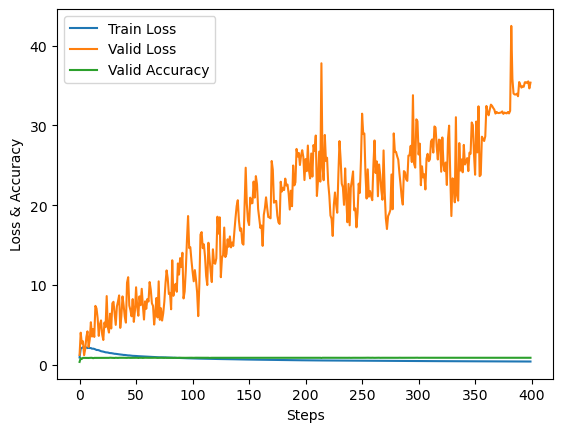

In [36]:
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] for i in records]
plt.plot(a, label='Train Loss')
plt.plot(b, label='Valid Loss')
plt.plot(c, label='Valid Accuracy')
plt.xlabel('Steps')
plt.ylabel('Loss & Accuracy')
plt.legend()


In [37]:
vals = []
for data, target in zip(test_data, test_label):
    data = Variable(torch.FloatTensor(data).view(1, -1))
    target = Variable(torch.LongTensor(np.array([target])))
    output = model(data)
    val = rightness(output, target)
    vals.append(val)

rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0].data.numpy() / rights[1]
print(right_rate)

0.8656945510360706


In [38]:
torch.save(model, 'bow.mdl')    # 保存模型
# model = torch.load('bow.mdl')   # 提取模型